# Title : Music Genre Classification with Different Preprocessing Approaches
---

## Objective
- The objective of this assignment is to develop a multi-class classification model. The goal is to classify the genre of the song’s track. This dataset contains audio statistics of the top 2000 tracks. The
data contains about 17 columns each describing the track and its qualities.

## Import libraries

In [ ]:
import scipy
import re
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import xgboost as xgb
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, ConfusionMatrixDisplay, f1_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras import regularizers
from xgboost import XGBClassifier

## Loading data

In [ ]:
raw_data_path = "./datas/songs_normalize.csv"
raw_data = pd.read_csv(raw_data_path)
print(raw_data)

              artist                                    song  duration_ms  \
0     Britney Spears                  Oops!...I Did It Again       211160   
1          blink-182                    All The Small Things       167066   
2         Faith Hill                                 Breathe       250546   
3           Bon Jovi                            It's My Life       224493   
4             *NSYNC                             Bye Bye Bye       200560   
...              ...                                     ...          ...   
1995  Jonas Brothers                                  Sucker       181026   
1996    Taylor Swift                            Cruel Summer       178426   
1997    Blanco Brown                              The Git Up       200593   
1998       Sam Smith  Dancing With A Stranger (with Normani)       171029   
1999     Post Malone                                 Circles       215280   

      explicit  year  popularity  danceability  energy  loudness  mode  \
0

In [ ]:
# check whether copy the raw_data well or not
data = raw_data.copy()
print(data.head())

           artist                    song  duration_ms  explicit  year  \
0  Britney Spears  Oops!...I Did It Again       211160     False  2000   
1       blink-182    All The Small Things       167066     False  1999   
2      Faith Hill                 Breathe       250546     False  1999   
3        Bon Jovi            It's My Life       224493     False  2000   
4          *NSYNC             Bye Bye Bye       200560     False  2000   

   popularity  danceability  energy  loudness  mode  speechiness  \
0          77         0.751   0.834    -5.444     0       0.0437   
1          79         0.434   0.897    -4.918     1       0.0488   
2          66         0.529   0.496    -9.007     1       0.0290   
3          78         0.551   0.913    -4.063     0       0.0466   
4          65         0.614   0.928    -4.806     0       0.0516   

   acousticness  instrumentalness  liveness  valence    tempo         genre  
0        0.3000          0.000018    0.3550    0.894   95.053       

In [ ]:
# Overall dataset statistics
print(data.describe().round(2))

       duration_ms     year  popularity  danceability   energy  loudness  \
count      2000.00  2000.00     2000.00       2000.00  2000.00   2000.00   
mean     228748.12  2009.49       59.87          0.67     0.72     -5.51   
std       39136.57     5.86       21.34          0.14     0.15      1.93   
min      113000.00  1998.00        0.00          0.13     0.05    -20.51   
25%      203580.00  2004.00       56.00          0.58     0.62     -6.49   
50%      223279.50  2010.00       65.50          0.68     0.74     -5.28   
75%      248133.00  2015.00       73.00          0.76     0.84     -4.17   
max      484146.00  2020.00       89.00          0.98     1.00     -0.28   

          mode  speechiness  acousticness  instrumentalness  liveness  \
count  2000.00      2000.00       2000.00           2000.00   2000.00   
mean      0.55         0.10          0.13              0.02      0.18   
std       0.50         0.10          0.17              0.09      0.14   
min       0.00         

In [ ]:
# Checking missing values
print(data.isnull().sum())

artist              0
song                0
duration_ms         0
explicit            0
year                0
popularity          0
danceability        0
energy              0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
genre               0
dtype: int64


##### Result: no missing data

### EDA

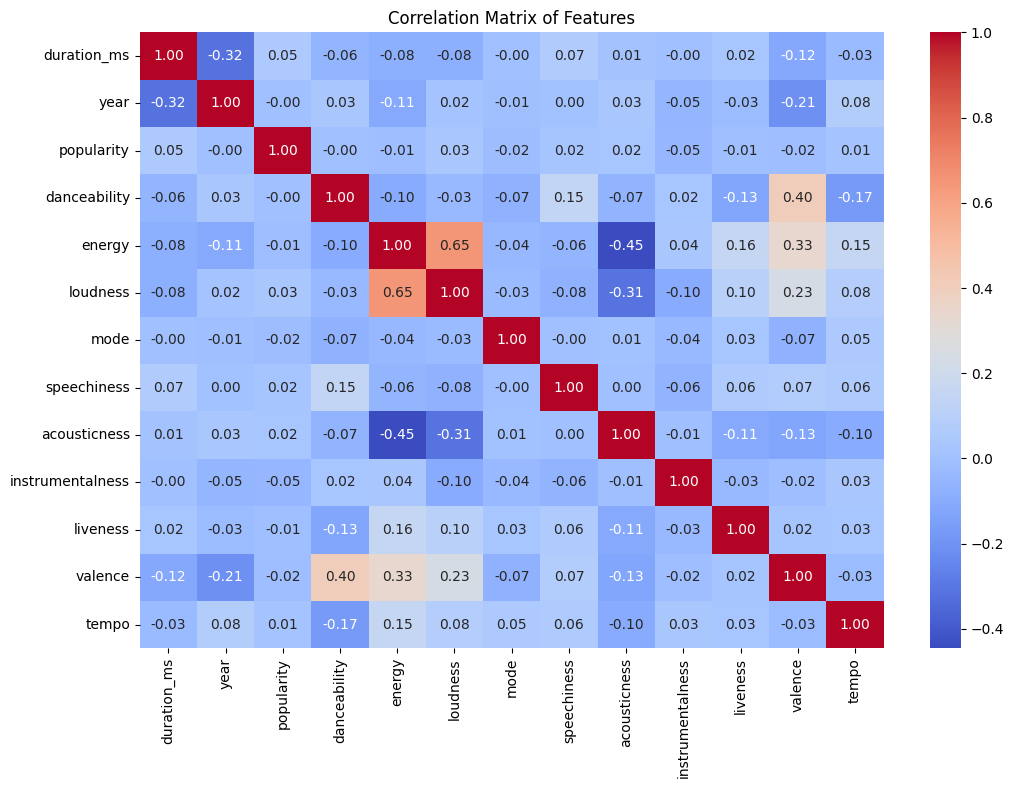

In [ ]:
#Numerical data correlation
numeric_data = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_data.corr()

# Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Features")
plt.show()

##### Analysis
- Based on the correlations, there is possitive meaningful correlation between loudness and energy.

### Data preprocessing

In [ ]:
# Check duplicates.
duplicates = data.duplicated()
print(duplicates.sum())
duplicated_mask = data.duplicated(keep=False)
duplicated_rows = data[duplicated_mask]
duplicated_groups = duplicated_rows.sort_values(by=list(data.columns)).groupby(list(data.columns))

# Check what data is duplicated.
for group_name, group in duplicated_groups:
    print(f"\nGroup:\n{group}")

59

Group:
             artist            song  duration_ms  explicit  year  popularity  \
1456  Ariana Grande  Love Me Harder       236133     False  2014          74   
1562  Ariana Grande  Love Me Harder       236133     False  2014          74   

      danceability  energy  loudness  mode  speechiness  acousticness  \
1456         0.472   0.714    -4.389     0       0.0334       0.00937   
1562         0.472   0.714    -4.389     0       0.0334       0.00937   

      instrumentalness  liveness  valence   tempo genre  
1456               0.0    0.0764     0.24  98.992   pop  
1562               0.0    0.0764     0.24  98.992   pop  

Group:
        artist       song  duration_ms  explicit  year  popularity  \
324  Baby Bash  Suga Suga       239026     False  2003          73   
431  Baby Bash  Suga Suga       239026     False  2003          73   

     danceability  energy  loudness  mode  speechiness  acousticness  \
324         0.662   0.748    -3.041     0        0.268         

In [ ]:
# Drop duplicates.
data = data.drop_duplicates()

# Check whether duplicate well or not.
duplicates_after_removal = data.duplicated().sum()
print(duplicates_after_removal)

0


##### Success to drop duplicates.

In [ ]:
# Convert the genre column into a list by splitting
data['genre'] = data['genre'].apply(lambda x: [genre.strip() for genre in x.split(',')] if isinstance(x, str) else x)
all_genres = [genre for sublist in data['genre'] for genre in sublist if genre != '']
unique_genres = set(all_genres)
print(unique_genres)

{'Dance/Electronic', 'set()', 'hip hop', 'country', 'jazz', 'easy listening', 'R&B', 'latin', 'World/Traditional', 'rock', 'Folk/Acoustic', 'blues', 'metal', 'pop', 'classical'}


In [ ]:
# Check the count of rows with 'set()'
set_rows_count = data[data['genre'].apply(lambda genres: 'set()' in genres)].shape[0]
print(set_rows_count)

22


##### The count of the rows(22) seems like not effective on the reaults, so remove the rows.

In [ ]:
# Remove the rows with 'set()'

data_clean = data[~data['genre'].apply(lambda genres: 'set()' in genres)]
print(data_clean.shape)

(1919, 17)


In [ ]:
print(data_clean)

              artist                                    song  duration_ms  \
0     Britney Spears                  Oops!...I Did It Again       211160   
1          blink-182                    All The Small Things       167066   
2         Faith Hill                                 Breathe       250546   
3           Bon Jovi                            It's My Life       224493   
4             *NSYNC                             Bye Bye Bye       200560   
...              ...                                     ...          ...   
1995  Jonas Brothers                                  Sucker       181026   
1996    Taylor Swift                            Cruel Summer       178426   
1997    Blanco Brown                              The Git Up       200593   
1998       Sam Smith  Dancing With A Stranger (with Normani)       171029   
1999     Post Malone                                 Circles       215280   

      explicit  year  popularity  danceability  energy  loudness  mode  \
0

Result: The rows with set() were removed.

In [ ]:
# Explode the genre with several values.
data_expanded = data_clean.explode('genre')
print(data_expanded.shape)

(3566, 17)


In [ ]:
print(data_expanded)

              artist                                    song  duration_ms  \
0     Britney Spears                  Oops!...I Did It Again       211160   
1          blink-182                    All The Small Things       167066   
1          blink-182                    All The Small Things       167066   
2         Faith Hill                                 Breathe       250546   
2         Faith Hill                                 Breathe       250546   
...              ...                                     ...          ...   
1996    Taylor Swift                            Cruel Summer       178426   
1997    Blanco Brown                              The Git Up       200593   
1997    Blanco Brown                              The Git Up       200593   
1998       Sam Smith  Dancing With A Stranger (with Normani)       171029   
1999     Post Malone                                 Circles       215280   

      explicit  year  popularity  danceability  energy  loudness  mode  \
0

In [ ]:
# Concatenate artist and song, then remove special characters
data_expanded['artist_song'] = data_expanded['artist'] + ' ' + data_expanded['song']

def remove_special_characters(text):
    return re.sub(r'[^\w\s]', '', text)

data_expanded['artist_song'] = data_expanded['artist_song'].apply(remove_special_characters)

In [ ]:
# Select numerical features
numeric_features = data_expanded[['duration_ms', 'year', 'popularity', 'danceability', 'energy', 'loudness',
                               'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]

In [ ]:
# Vectorize text data using TF-IDF
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=1000)
text_features = tfidf_vectorizer.fit_transform(data_expanded['artist_song'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Split data into training and test sets
X_train_num, X_test_num, X_train_text, X_test_text, y_train, y_test = train_test_split(
    numeric_features, text_features, data_expanded['genre'], test_size=0.3, random_state=50)

In [ ]:
# Fit the scaler on the training data
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)

In [ ]:
# Transform the test data using the fitted scaler
X_test_num_scaled = scaler.transform(X_test_num)

In [ ]:
# Combine the numeric and text features
X_train = scipy.sparse.hstack((X_train_text, X_train_num_scaled))
X_test = scipy.sparse.hstack((X_test_text, X_test_num_scaled))

In [ ]:
# Encode genre using One-Hot Encoding
print(y_train.head())
print(y_test.head())
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

246     R&B
1244    pop
1123    pop
1955    pop
1541    pop
Name: genre, dtype: object
1649    pop
1838    pop
22      pop
1767    pop
1288    pop
Name: genre, dtype: object


#### Random forest training function

In [ ]:
def train_rf_model(X_train, y_train_encoded, class_weight=None, n_estimators=100, random_state=50):
    """
    Parameters:
    X_train (array): Training features.
    y_train_encoded (array): One-hot encoded training labels.
    class_weight (str or dict): Weighting strategy for classes. Default is None.
    n_estimators (int): Number of trees in the forest. Default is 100.
    random_state (int): Random seed for reproducibility. Default is 50.

    Returns:
    RandomForestClassifier: Trained Random Forest model.
    """
    # Train the Random Forest model with the specified class_weight and number of estimators
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state, class_weight=class_weight)
    cross_val_scores = cross_val_score(rf_model, X_train, y_train_encoded, cv=5, scoring='accuracy')
    rf_model.fit(X_train, y_train_encoded)

    print(f"Cross-validation scores: {cross_val_scores}")
    print(f"Mean accuracy across folds: {cross_val_scores.mean()}")

    return rf_model

In [ ]:
def evaluate_rf_model(rf_model, X_test, y_test_encoded, n_classes=14):
    """
    Parameters:
    rf_model (RandomForestClassifier): Trained Random Forest model.
    X_test (array): Test features.
    y_test_encoded (array): One-hot encoded test labels.
    n_classes (int): Total number of classes in the dataset (default: 14).

    Returns:
    dict: Dictionary containing accuracy, F1-score, classification report, confusion matrix, and ROC curves.
    """
    # Predict on test set
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)

    # Convert y_pred to class indices
    y_pred_indices = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class indices if needed

    # Calculate accuracy and F1-score
    accuracy = accuracy_score(np.argmax(y_test_encoded, axis=1), y_pred_indices)
    f1 = f1_score(np.argmax(y_test_encoded, axis=1), y_pred_indices, average='weighted')

    # Generate classification report and confusion matrix
    class_report = classification_report(np.argmax(y_test_encoded, axis=1), y_pred_indices, labels=np.arange(n_classes), zero_division=0)

    # Print result
    print(f"Accuracy: {accuracy}")
    print(f"F1-score: {f1}")
    print("Classification report:")
    print(class_report)

    # Confusion matrix
    cm = confusion_matrix(np.argmax(y_test_encoded, axis=1), y_pred_indices, labels=np.arange(n_classes))

    # Plot confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(n_classes)).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # Calculate ROC curve and AUC for each class
    y_pred_proba = rf_model.predict_proba(X_test)  # Get probability predictions for ROC curve
    y_pred_proba = np.swapaxes(y_pred_proba, 0, 1)  # Swap axes to match the shape
    y_pred_proba = y_pred_proba[:, :, 1]  # Use the probabilities for class 1

    n_classes = y_test_encoded.shape[1]
    y_test_bin = label_binarize(np.argmax(y_test_encoded, axis=1), classes=np.arange(n_classes))  # Binarize test labels for ROC

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure()
    colors = ['blue', 'red', 'green', 'orange', 'purple']  # Add more colors if needed
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class')
    plt.legend(loc="lower right")
    plt.show()

    # Return results
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'classification_report': class_report,
        'confusion_matrix': cm
    }

Cross-validation scores: [0.136      0.15430862 0.14228457 0.13026052 0.13226453]
Mean accuracy across folds: 0.1390236472945892
Accuracy: 0.15981308411214953
F1-score: 0.15762336912386302
Classification report:
              precision    recall  f1-score   support

           0       0.08      0.26      0.12       105
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00       116
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         0
           8       0.13      0.07      0.09       236
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00        22
          11       0.00      0.00      0.00        22
          12       0.29      0.26      0.27       483
          13       0.06      0.

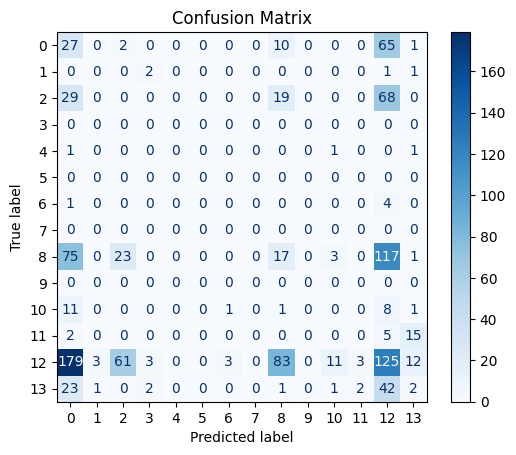

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


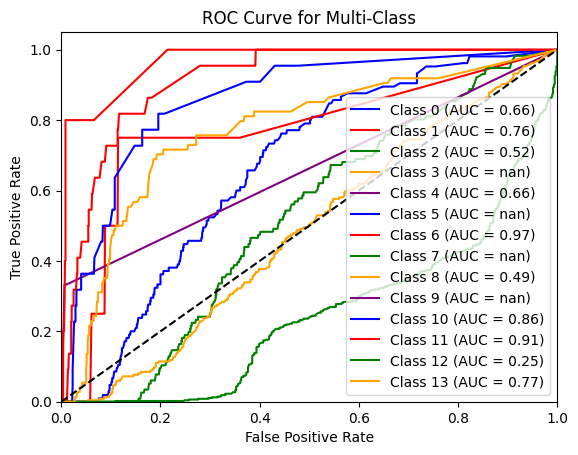

In [ ]:
# Random forest normal
rf_model_normal = train_rf_model(X_train, y_train_encoded, n_estimators=100, random_state=50)
results = evaluate_rf_model(rf_model_normal, X_test, y_test_encoded)

#### Random forest normal
- **Confusion Matrix Analysis:** Struggles with minority genres like folk, country, and metal. Performs well on majority genres such as hip hop and pop.
- **Error Analysis:** High false negatives for minority genres due to class imbalance. Overfitting observed on frequent genres.

Cross-validation scores: [0.072      0.08617234 0.05611222 0.07815631 0.08016032]
Mean accuracy across folds: 0.07452024048096191
Accuracy: 0.08504672897196262
F1-score: 0.08343559716729783
Classification report:
              precision    recall  f1-score   support

           0       0.07      0.29      0.11       105
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00       116
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         0
           8       0.04      0.03      0.03       236
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00        22
          11       0.00      0.00      0.00        22
          12       0.20      0.11      0.14       483
          13       0.00      0

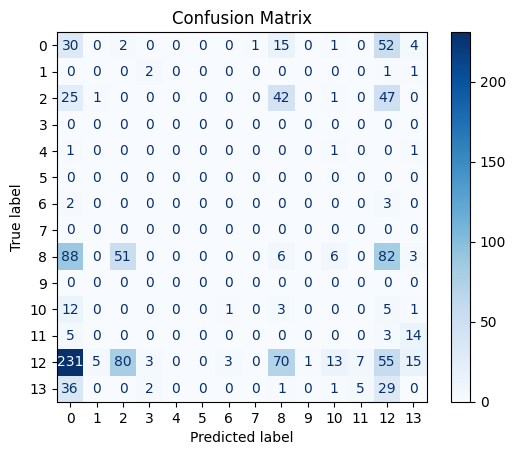

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


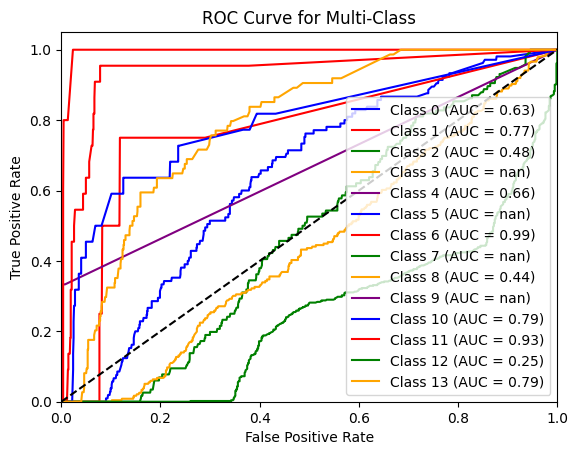

In [ ]:
# Random forest("class_weight = 'balanced'")
rf_model_balanced = train_rf_model(X_train=X_train, y_train_encoded=y_train_encoded, class_weight= 'balanced', n_estimators=100, random_state=50)
results = evaluate_rf_model(rf_model_balanced, X_test, y_test_encoded)

#### Random forest(class_weight = 'balanced')

- When the Random Forest model was initially applied, the overall accuracy and F1-score were very low, so I applied the `class_weight='balanced'`**parameter** option to address the class imbalance issue.
- **Confusion Matrix Analysis:** Balanced class weights help improve recall on minority genres, but introduces more false positives.
- **Error Analysis:** Improved recall on rare genres but increases false positives in the majority classes. The model slightly overfits due to class balancing.

Cross-validation scores: [0.052      0.08617234 0.06613226 0.06412826 0.06813627]
Mean accuracy across folds: 0.06731382765531062
Accuracy: 0.0794392523364486
F1-score: 0.07601155715926411
Classification report:
              precision    recall  f1-score   support

           0       0.07      0.30      0.11       105
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00       116
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         0
           8       0.04      0.02      0.03       236
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00        22
          11       0.00      0.00      0.00        22
          12       0.18      0.10      0.13       483
          13       0.00      0.

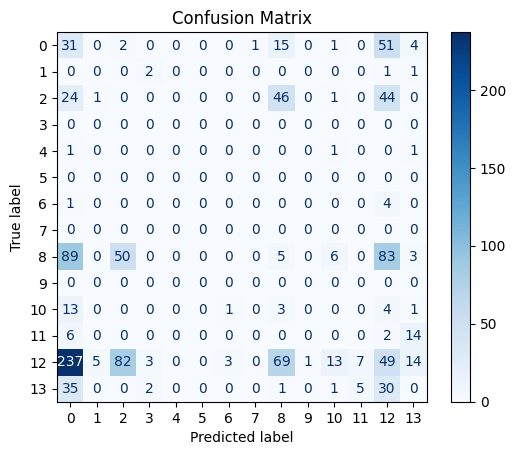

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


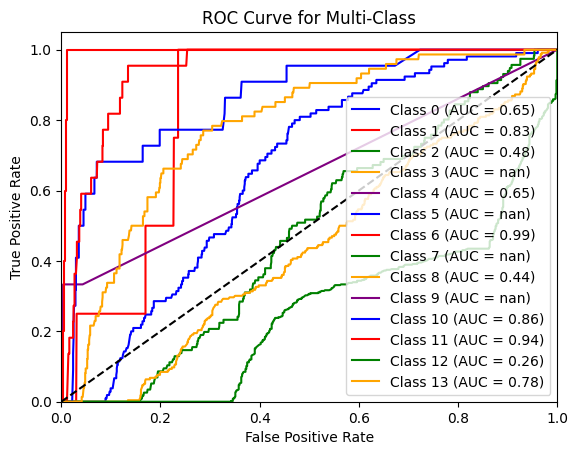

In [ ]:
# Random forest("class_weight = 'balanced', n_estimators = 1000")
rf_model_balanced_1000 = train_rf_model(X_train, y_train_encoded, class_weight= 'balanced', n_estimators=1000, random_state=50)
results = evaluate_rf_model(rf_model_balanced_1000, X_test, y_test_encoded)

#### Random forest(class_weight = 'balanced', n_estimators = 1000)
- **Confusion Matrix Analysis:** Better recall for majority genres, but overfitting on minority genres with rare occurrence (e.g., folk and country).
- **Error Analysis:** High number of misclassifications for minority genres, despite the increase in estimators. Overfitting persists due to a high number of trees.


#### Overall analysis about Random forest
- I applied the `class_weight='balanced'` parameter to address the class imbalance, but the accuracy and F1-score actually decreased.

- Attempted to apply SMOTE, but due to the extremely imbalanced class distribution in the dataset, an error occurred, preventing further progress.

- Therefore, I decided to try using a different model(Neural network).

## Neural network

### Neural Network model training function

In [ ]:
def train_nn_model(X_train, y_train, input_shape, output_shape, dropout_rate=0.3, activation_function='relu', learning_rate=0.001, epochs=10, batch_size=32, validation_split=0.3, l2_reg=0):
    """
    Parameters:
    X_train (array): Training features.
    y_train (array): One-hot encoded training labels.
    input_shape (int): Number of input features.
    output_shape (int): Number of output classes.
    dropout_rate (float): Dropout rate to be applied for regularization. Default is 0.3.
    activation_function (str): Activation function to use in hidden layers. Default is 'relu'.
    learning_rate (float): Learning rate for the optimizer. Default is 0.001.
    epochs (int): Number of epochs to train the model. Default is 10.
    batch_size (int): Batch size for training. Default is 32.
    validation_split (float): Fraction of the training data to be used as validation data. Default is 0.3.
    l2_reg (float): L2 regularization factor. If 0, no regularization is applied. Default is 0 (no regularization).

    Returns:
    model_nn (tf.keras.Sequential): Trained Neural Network model.
    history_nn (History): History object containing training details.
    """
    # Whether applying the regularizer or not
    if l2_reg > 0:
        regularizer = regularizers.l2(l2_reg)
    else:
        regularizer = None

    # Build the model with L2 regularization only on hidden layers
    model_nn = tf.keras.Sequential([
        # First hidden layer with L2 regularization
        tf.keras.layers.Dense(128, activation=activation_function, input_shape=(input_shape,),
                              kernel_regularizer=regularizer),  # Applied L2 regularization
        tf.keras.layers.Dropout(dropout_rate),  # Dropout with configurable rate

        # Second hidden layer with L2 regularization
        tf.keras.layers.Dense(64, activation=activation_function, kernel_regularizer=regularizer),  # Applied L2 regularization

        # Output layer without L2 regularization
        tf.keras.layers.Dense(output_shape, activation='softmax')  # Output layer for multi-class classification
    ])

    # Configure the optimizer with the given learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model
    model_nn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history_nn = model_nn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

    return model_nn, history_nn


### Neural Network model evaluation function

In [ ]:
def evaluate_nn_model(model_nn, X_test, y_test, encoder, n_classes=14, best=False):
    """
    Evaluate the Neural Network model and print evaluation results (accuracy, F1 score, classification report, confusion matrix, and ROC-AUC curve).

    Parameters:
    model_nn (tf.keras.Sequential): Trained Neural Network model.
    X_test (array): Test features.
    y_test (array): One-hot encoded test labels.
    encoder (OneHotEncoder): Fitted OneHotEncoder object for decoding labels.
    n_classes (int): Total number of classes in the dataset (default: 14).
    best (bool): If True, save the actual and predicted labels to a CSV file.

    Returns:
    dict: A dictionary containing test accuracy, F1 score, classification report, confusion matrix, and ROC-AUC curve.
    """
    # Evaluate the model on the test set
    test_loss_nn, test_accuracy_nn = model_nn.evaluate(X_test, y_test, verbose=0)

    # Predict on the test set
    y_pred_probs_nn = model_nn.predict(X_test)
    y_pred_nn = np.argmax(y_pred_probs_nn, axis=1)

    # Convert one-hot encoded y_test back to labels
    y_test_labels_nn = np.argmax(y_test, axis=1)

    # If best is True, save actual and predicted labels to CSV file
    if best:
        df_predictions = pd.DataFrame({
            'Actual': y_test_labels_nn,
            'Predicted': y_pred_nn
        })
        df_predictions.to_csv("best_mode_result.csv", index=False)
        print(f"Predictions saved to best_mode_result.csv")

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test_labels_nn, y_pred_nn)
    f1 = f1_score(y_test_labels_nn, y_pred_nn, average='weighted')

    # Generate classification report with 14 classes (numbers only)
    class_report = classification_report(
        y_test_labels_nn, y_pred_nn, labels=np.arange(n_classes), zero_division=0
    )

    for index, genre in enumerate(encoder.categories_[0]):
      print(f"Class {index}: {genre}")
    print(f"Test Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print("Classification Report:\n", class_report)

    # Confusion Matrix with 14 classes (numbers only)
    cm_nn = confusion_matrix(y_test_labels_nn, y_pred_nn, labels=np.arange(n_classes))
    ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=np.arange(n_classes)).plot(cmap='Blues')
    plt.title("Confusion Matrix - Neural Network")
    plt.show()

    # ROC-AUC Curve with fixed class order (numbers only)
    y_test_bin = label_binarize(y_test_labels_nn, classes=np.arange(n_classes))

    # Ensure y_pred_probs_nn has 14 columns (for 14 classes)
    if y_pred_probs_nn.shape[1] < n_classes:
        # Add missing columns (classes) with zero probabilities
        missing_classes = n_classes - y_pred_probs_nn.shape[1]
        y_pred_probs_nn = np.hstack([y_pred_probs_nn, np.zeros((y_pred_probs_nn.shape[0], missing_classes))])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        if np.sum(y_test_bin[:, i]) > 0:  # Ensure that the class exists in the test set
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs_nn[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        else:
            fpr[i], tpr[i], roc_auc[i] = [0], [0], 0  # Default values for missing classes

    # Plot ROC curve for each class (numbers only)
    plt.figure()
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'gray', 'brown', 'pink', 'lime', 'navy']
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class (Neural Network)')
    plt.legend(loc="lower right")
    plt.show()

    # Return evaluation results as a dictionary
    return {
        'test_accuracy': accuracy,
        'f1_score': f1,
        'classification_report': class_report,
        'confusion_matrix': cm_nn,
        'roc_auc': roc_auc
    }

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.0934 - loss: 2.6335 - val_accuracy: 0.3164 - val_loss: 2.5479
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3161 - loss: 2.5080 - val_accuracy: 0.4059 - val_loss: 2.4227
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3887 - loss: 2.3799 - val_accuracy: 0.4192 - val_loss: 2.2741
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4140 - loss: 2.2251 - val_accuracy: 0.4419 - val_loss: 2.1084
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4541 - loss: 2.0367 - val_accuracy: 0.4379 - val_loss: 1.9472
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4591 - loss: 1.8929 - val_accuracy: 0.4393 - val_loss: 1.8179
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4473 - loss: 1.7717 - val_accuracy: 0.4339 - val_loss: 1.7251
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4734 - loss: 1.6434 - val_accuracy: 0.4366 - v

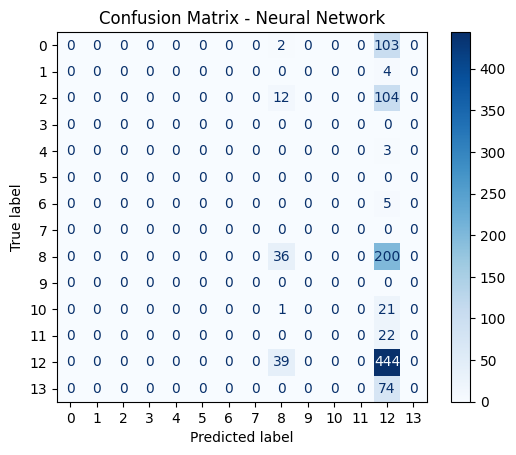

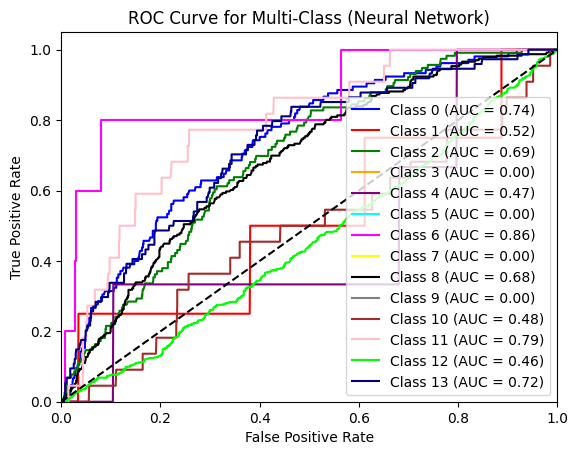

In [ ]:
# Neural Network model_normal
model_nn_1, history_nn_1 = train_nn_model(X_train, y_train_encoded, input_shape=X_train.shape[1], output_shape=y_train_encoded.shape[1], dropout_rate=0, activation_function='relu', learning_rate=0.0001)
nn_results_1 = evaluate_nn_model(model_nn_1, X_test, y_test_encoded, encoder)

#### Neural Network model_normal
- **Confusion Matrix Analysis:** Confuses genres that are musically similar (e.g., pop and rock). Poor performance on minority genres.
- **Error Analysis:** Misclassifies similar genres and fails to generalize well on rare genres. Overfitting is detected.


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3293 - loss: 2.5765 - val_accuracy: 0.4406 - val_loss: 2.4992
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4354 - loss: 2.4594 - val_accuracy: 0.4433 - val_loss: 2.3878
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4343 - loss: 2.3372 - val_accuracy: 0.4433 - val_loss: 2.2558
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4163 - loss: 2.2140 - val_accuracy: 0.4433 - val_loss: 2.1159
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4313 - loss: 2.0618 - val_accuracy: 0.4433 - val_loss: 1.9848
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4243 - loss: 1.9452 - val_accuracy: 0.4433 - val_loss: 1.8802
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4256 - loss: 1.8291 - val_accuracy: 0.4433 - val_loss: 1.7972
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4152 - loss: 1.7802 - val_accuracy: 0.4433 - val_loss: 1.7306

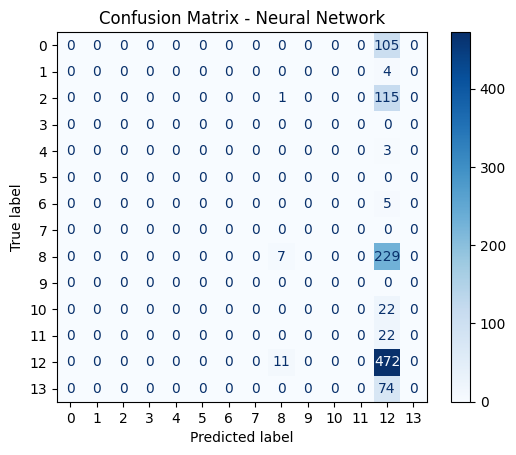

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


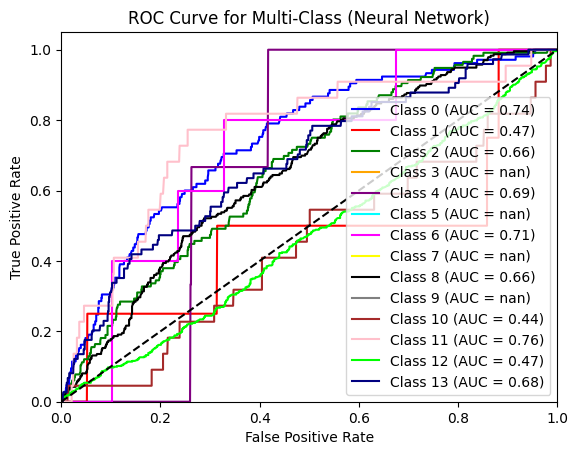

In [ ]:
# Neural Network model_dropout(0.3)
model_nn_2, history_nn_2 = train_nn_model(X_train, y_train_encoded, input_shape=X_train.shape[1], output_shape=y_train_encoded.shape[1], dropout_rate=0.3, activation_function='relu', learning_rate=0.0001)
nn_results_2 = evaluate_nn_model(model_nn_2, X_test, y_test_encoded, encoder)

#### Neural Network model_dropout(0.3)
- **Confusion Matrix Analysis:** Dropout helps with generalization, reducing overfitting, but class confusion remains for pop and rock.
- **Error Analysis:** Dropout reduces overfitting but doesn't fully resolve confusion between similar genres.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1203 - loss: 2.6260 - val_accuracy: 0.2176 - val_loss: 2.5518
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2340 - loss: 2.5271 - val_accuracy: 0.3178 - val_loss: 2.4533
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3271 - loss: 2.4129 - val_accuracy: 0.3805 - val_loss: 2.3463
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3777 - loss: 2.2930 - val_accuracy: 0.4166 - val_loss: 2.2258
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4135 - loss: 2.1566 - val_accuracy: 0.4259 - val_loss: 2.0911
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4178 - loss: 2.0280 - val_accuracy: 0.4366 - val_loss: 1.9459
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4568 - loss: 1.8697 - val_accuracy: 0.4433 - val_loss: 1.8075
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4562 - loss: 1.7444 - val_accuracy: 0.4513 - val_loss

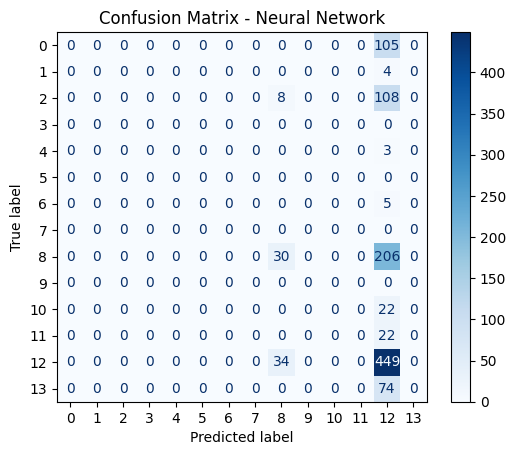

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


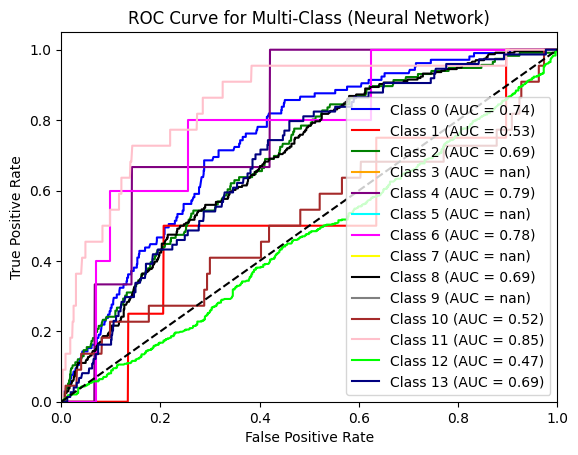

In [ ]:
# Neural Network model_activation_function_tanh(0.3)
model_nn_3, history_nn_3 = train_nn_model(X_train, y_train_encoded, input_shape=X_train.shape[1], output_shape=y_train_encoded.shape[1], dropout_rate=0.3, activation_function='tanh', learning_rate=0.0001)
nn_results_3 = evaluate_nn_model(model_nn_1, X_test, y_test_encoded, encoder)

#### Neural Network model_activation_function_tanh(0.3)
- **Confusion Matrix Analysis:** Slow convergence and high confusion between closely related genres.
- **Error Analysis:** Tanh slows down learning and leads to misclassifications due to its saturated gradients. This results in underfitting.



Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0259 - loss: 2.9348 - val_accuracy: 0.1055 - val_loss: 2.5955
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0966 - loss: 2.4908 - val_accuracy: 0.4192 - val_loss: 2.2354
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3551 - loss: 2.1729 - val_accuracy: 0.4433 - val_loss: 1.9949
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4443 - loss: 1.9579 - val_accuracy: 0.4433 - val_loss: 1.8490
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4447 - loss: 1.8355 - val_accuracy: 0.4433 - val_loss: 1.7634
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4433 - loss: 1.7659 - val_accuracy: 0.4433 - val_loss: 1.7116
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4254 - loss: 1.7415 - val_accuracy: 0.4433 - val_loss: 1.6790
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4340 - loss: 1.6925 - val_accuracy: 0.4433 - val_loss: 1.6575
Ep

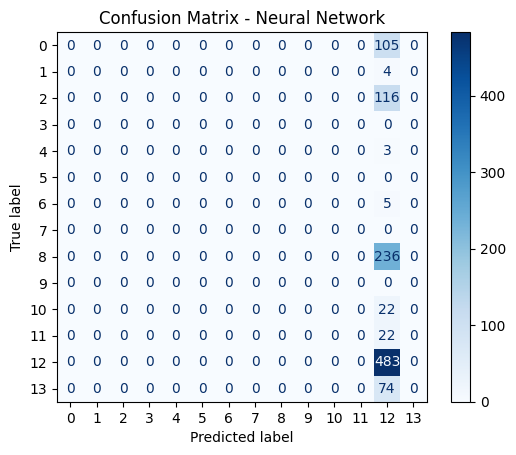

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


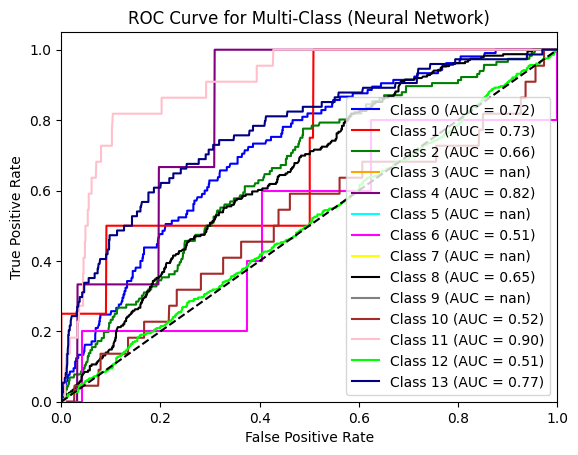

In [ ]:
# Neural Network model_activation_function_sig(0.3)
model_nn_3, history_nn_3 = train_nn_model(X_train, y_train_encoded, input_shape=X_train.shape[1], output_shape=y_train_encoded.shape[1], dropout_rate=0.3, activation_function='sigmoid', learning_rate=0.0001)
nn_results_3 = evaluate_nn_model(model_nn_3, X_test, y_test_encoded, encoder)

#### Neural Network model_activation_function_sig(0.3)
- Confusion Matrix Analysis: Struggles with minority genres due to underfitting.
- Error Analysis: High false negatives for rare genres (e.g., blues, folk), underfitting observed as sigmoid saturates early, leading to less effective learning.


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3740 - loss: 1.8639 - val_accuracy: 0.4246 - val_loss: 1.4763
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4777 - loss: 1.3194 - val_accuracy: 0.3818 - val_loss: 1.4561
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5303 - loss: 1.1455 - val_accuracy: 0.3378 - val_loss: 1.5216
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5819 - loss: 0.9696 - val_accuracy: 0.3044 - val_loss: 1.5653
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6048 - loss: 0.8921 - val_accuracy: 0.3124 - val_loss: 1.7345
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6101 - loss: 0.8393 - val_accuracy: 0.3004 - val_loss: 1.8265
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6238 - loss: 0.8136 - val_accuracy: 0.2817 - val_loss: 1.8809
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6645 - loss: 0.7343 - val_accuracy: 0.2830 - val_loss: 1.9990
E

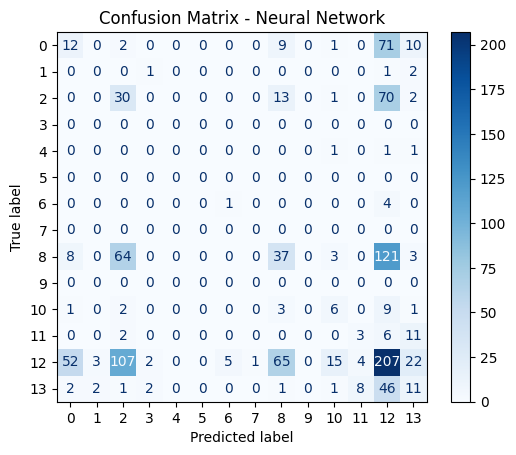

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


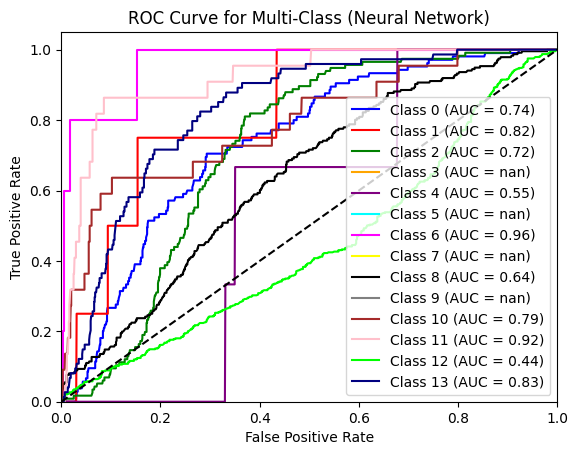

In [ ]:
# Neural Network model_activation_function_relu(0.3)_learning_rate_0.01
model_nn_4, history_nn_4 = train_nn_model(X_train, y_train_encoded, input_shape=X_train.shape[1], output_shape=y_train_encoded.shape[1], dropout_rate=0.3, activation_function='relu', learning_rate=0.01)
nn_results_4 = evaluate_nn_model(model_nn_4, X_test, y_test_encoded, encoder)

#### Neural Network model_activation_function_relu(0.3)_learning_rate_0.01
- **Confusion Matrix Analysis:** ReLU improves performance, but there is still confusion between genres like pop and rock.
- **Error Analysis:** Overfitting after extended epochs, although dropout and learning rate control generalization better than tanh and sigmoid activations.


## XG boost

#### Train an XGBoost multi-class classification model.


In [ ]:
def train_xgboost_model(X_train, y_train, learning_rate=0.1, n_estimators=100, max_depth=6):
    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()

    # Fit the label encoder and transform the training labels
    y_train_encoded = label_encoder.fit_transform(y_train)

    # Create and train the XGBClassifier
    model_xgb = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth,
                              use_label_encoder=False, eval_metric='mlogloss')
    model_xgb.fit(X_train, y_train_encoded)

    # Return the trained model and the label encoder
    return model_xgb, label_encoder

#### Evaluate the XGBoost multi-class classification model

In [ ]:
def evaluate_xgboost_model(model_xgb, X_test, y_test, label_encoder, n_classes=14):
    """
    Evaluate XGBoost model, print evaluation metrics, and plot confusion matrix and ROC-AUC.

    Parameters:
    model_xgb (XGBClassifier): Trained XGBoost model.
    X_test (array): Test features.
    y_test (array): Actual labels (in string format).
    label_encoder (LabelEncoder): Encoder used to encode the genre labels.
    n_classes (int): Number of classes in the dataset (default: 14).
    """
    # Ensure that y_test is encoded as numbers using the label encoder
    y_test_encoded = label_encoder.transform(y_test)

    # Predict on the test set
    y_pred_probs_xgb = model_xgb.predict_proba(X_test)  # Get probabilities for ROC
    y_pred_xgb = np.argmax(y_pred_probs_xgb, axis=1)

    # Accuracy and F1 score
    accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
    f1 = f1_score(y_test_encoded, y_pred_xgb, average='weighted')

    # Generate classification report and confusion matrix
    class_report = classification_report(y_test_encoded, y_pred_xgb, labels=np.arange(n_classes), zero_division=0)

    for index, genre in enumerate(label_encoder.classes_):
      print(f"Class {index}: {genre}")
    print(f"Test Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print("Classification Report:\n", class_report)

    # Confusion Matrix
    cm_xgb = confusion_matrix(y_test_encoded, y_pred_xgb, labels=np.arange(n_classes))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)

    # Adjust ticks for confusion matrix
    disp.plot(cmap='Blues')
    plt.xticks(np.arange(n_classes), np.arange(n_classes))  # Set X-axis ticks and labels
    plt.yticks(np.arange(n_classes), np.arange(n_classes))  # Set Y-axis ticks and labels
    plt.title("Confusion Matrix - XGBoost")
    plt.show()

    # ROC-AUC Calculation
    y_test_bin = label_binarize(y_test_encoded, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        if np.sum(y_test_bin[:, i]) > 0:  # Ensure that the class is present in the test set
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs_xgb[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        else:
            fpr[i], tpr[i], roc_auc[i] = [0], [0], 0  # Default values for missing classes

    # Plot ROC curve for each class
    plt.figure()
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'gray', 'brown', 'pink', 'lime', 'navy']
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class (XGBoost)')
    plt.legend(loc="lower right")
    plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:29:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Class 0: Dance/Electronic
Class 1: Folk/Acoustic
Class 2: R&B
Class 3: World/Traditional
Class 4: blues
Class 5: classical
Class 6: country
Class 7: easy listening
Class 8: hip hop
Class 9: jazz
Class 10: latin
Class 11: metal
Class 12: pop
Class 13: rock
Test Accuracy: 0.28598130841121494
F1 Score: 0.25936638022774633
Classification Report:
               precision    recall  f1-score   support

           0       0.09      0.06      0.07       105
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00       116
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         0
           8       0.27      0.19      0.22       236
           9       0.00      0.00      0.00         0
          10       0.08      0.09      0.09        22
      

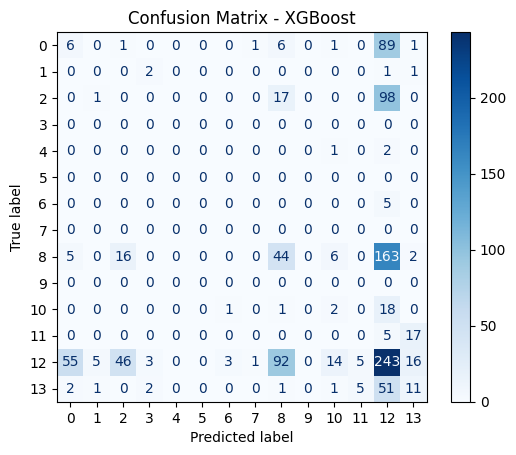

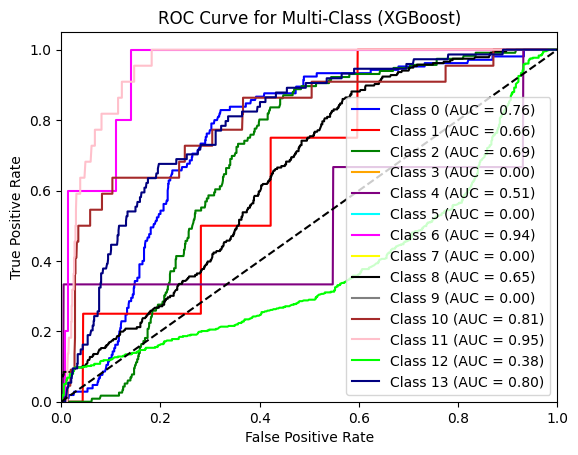

In [ ]:
# XGBoost Basic model
model_xgb, label_encoder = train_xgboost_model(X_train, y_train)
evaluate_xgboost_model(model_xgb, X_test, y_test, label_encoder)

#### XGBoost Basic model
- **Confusion Matrix Analysis:** Performs well for popular genres like hip hop, but struggles with minority classes.
- **Error Analysis:** High recall for majority genres but underperforms on rare genres due to the imbalanced nature of the dataset. Overfitting is observed.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:39:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.24485981308411214
F1 Score: 0.23398864165846178
Classification Report:
               precision    recall  f1-score   support

           0       0.09      0.08      0.08       105
           1       0.00      0.00      0.00         4
           2       0.01      0.01      0.01       116
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         0
           8       0.25      0.20      0.22       236
           9       0.00      0.00      0.00         0
          10       0.08      0.09      0.08        22
          11       0.00      0.00      0.00        22
          12       0.33      0.40      0.36       483
          13       0.18      0.12      0.14        74

    accuracy                           0.24      1070
   macro avg       0.07      0.06      0.06  

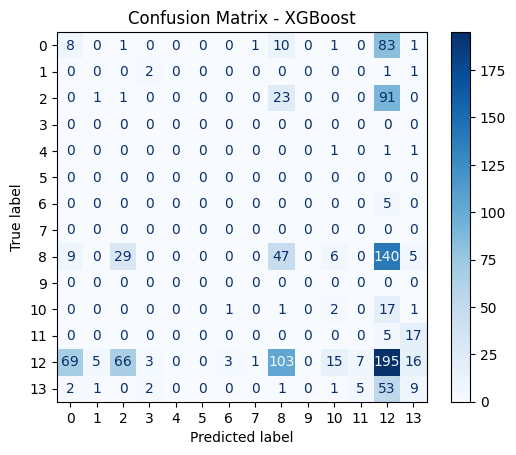

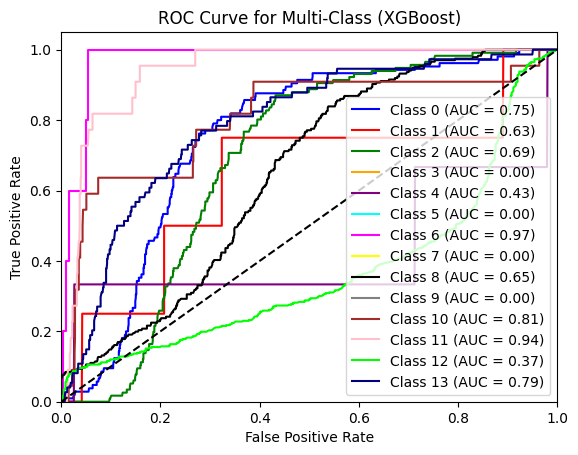

In [ ]:
# XGBoost model_n_estimators=200
model_xgb_200, label_encoder_200 = train_xgboost_model(X_train, y_train, n_estimators=200)
evaluate_xgboost_model(model_xgb_200, X_test, y_test, label_encoder_200)

#### XGBoost model_n_estimators=200
- Confusion Matrix Analysis: Overfits to majority genres, fails to generalize for minority genres.
- Error Analysis: Increasing estimators leads to overfitting. Misclassifies minority genres such as blues, folk, and country.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:40:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.411214953271028
F1 Score: 0.32445203881928286
Classification Report:
               precision    recall  f1-score   support

           0       0.12      0.03      0.05       105
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00       116
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         0
           8       0.39      0.18      0.24       236
           9       0.00      0.00      0.00         0
          10       0.12      0.09      0.11        22
          11       0.00      0.00      0.00        22
          12       0.44      0.80      0.57       483
          13       0.18      0.08      0.11        74

    accuracy                           0.41      1070
   macro avg       0.09      0.08      0.08    

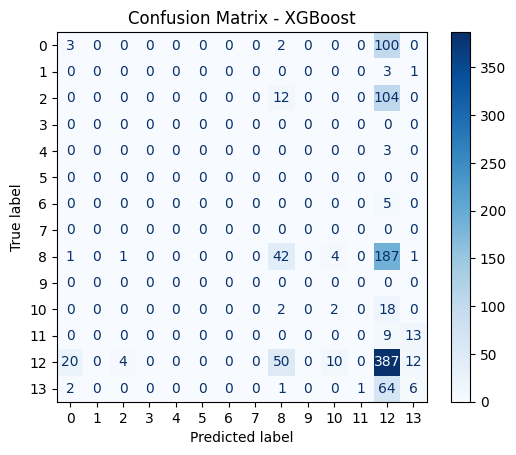

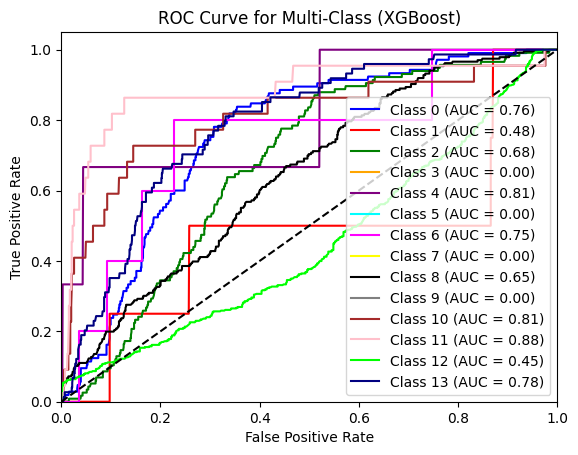

In [ ]:
# XGBoost model_learning_rate=0.01
model_xgb_001, label_encoder_001 = train_xgboost_model(X_train, y_train, learning_rate = 0.01)
evaluate_xgboost_model(model_xgb_001, X_test, y_test, label_encoder_001)

#### XGBoost model_learning_rate=0.01
- **Confusion Matrix Analysis:** Lower learning rate improves generalization but struggles with convergence speed.
- **Error Analysis:** Recall improved, but the slow convergence doesn't completely resolve the issue of misclassification for rare genres.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:40:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.41962616822429905
F1 Score: 0.3335316334051663
Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.04      0.06       105
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00       116
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         0
           8       0.36      0.19      0.25       236
           9       0.00      0.00      0.00         0
          10       0.17      0.05      0.07        22
          11       0.00      0.00      0.00        22
          12       0.45      0.81      0.58       483
          13       0.23      0.14      0.17        74

    accuracy                           0.42      1070
   macro avg       0.10      0.09      0.08   

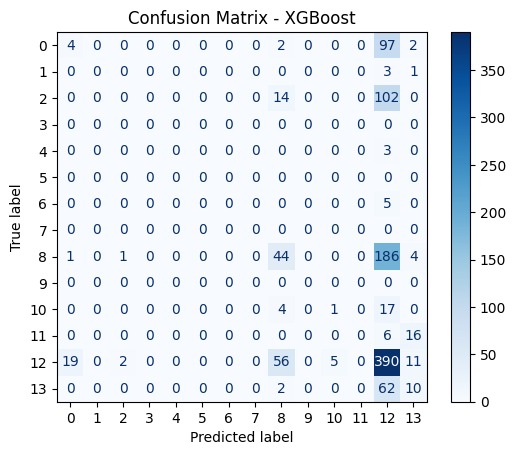

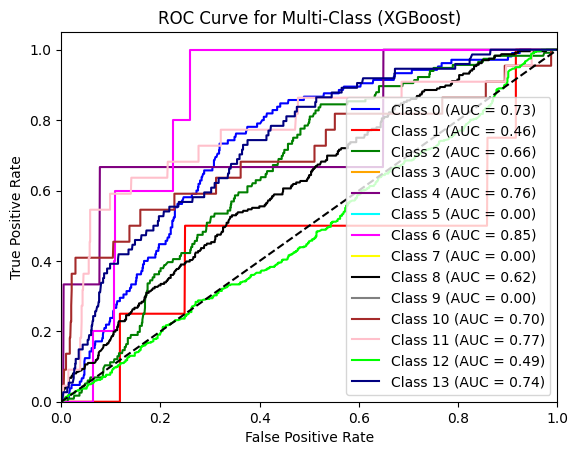

In [ ]:
# XGBoost model_learning_rate=0.001
model_xgb_0001, label_encoder_0001 = train_xgboost_model(X_train, y_train, learning_rate = 0.001)
evaluate_xgboost_model(model_xgb_0001, X_test, y_test, label_encoder_0001)

#### XGBoost model_learning_rate=0.001
- **Confusion Matrix Analysis:** Underfits due to an extremely low learning rate, misclassifies minority genres more frequently.
- **Error Analysis:** Underfitting is evident as the model is unable to learn effectively due to the very slow learning rate.


## Changed the way of data preprocessing

In [ ]:
data_v2 = data_clean.copy()
print(data_v2)

              artist                                    song  duration_ms  \
0     Britney Spears                  Oops!...I Did It Again       211160   
1          blink-182                    All The Small Things       167066   
2         Faith Hill                                 Breathe       250546   
3           Bon Jovi                            It's My Life       224493   
4             *NSYNC                             Bye Bye Bye       200560   
...              ...                                     ...          ...   
1995  Jonas Brothers                                  Sucker       181026   
1996    Taylor Swift                            Cruel Summer       178426   
1997    Blanco Brown                              The Git Up       200593   
1998       Sam Smith  Dancing With A Stranger (with Normani)       171029   
1999     Post Malone                                 Circles       215280   

      explicit  year  popularity  danceability  energy  loudness  mode  \
0

In [ ]:
# This function is treating the genres to one genres
def choose_genre(genres):
    if isinstance(genres, list):
        # If the first genre is 'pop' and there's more than one genre, pick the second one.
        if genres[0] == 'pop' and len(genres) > 1:
            return genres[1]
        else:
            return genres[0]  # Otherwise, pick the first genre
    return genres

In [ ]:
# Combine 'artist' and 'song' into a new 'artist_song' column
data_v2['artist_song'] = data_v2['artist'] + ' ' + data_v2['song']

In [ ]:
# Apply the genre selection function
data_v2['genre'] = data_v2['genre'].apply(choose_genre)

In [ ]:
print(data_v2)

              artist                                    song  duration_ms  \
0     Britney Spears                  Oops!...I Did It Again       211160   
1          blink-182                    All The Small Things       167066   
2         Faith Hill                                 Breathe       250546   
3           Bon Jovi                            It's My Life       224493   
4             *NSYNC                             Bye Bye Bye       200560   
...              ...                                     ...          ...   
1995  Jonas Brothers                                  Sucker       181026   
1996    Taylor Swift                            Cruel Summer       178426   
1997    Blanco Brown                              The Git Up       200593   
1998       Sam Smith  Dancing With A Stranger (with Normani)       171029   
1999     Post Malone                                 Circles       215280   

      explicit  year  popularity  danceability  energy  loudness  mode  \
0

In [ ]:
# Apply the choose_genre function to clean the 'genre' column
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_text_tfidf = tfidf_vectorizer.fit_transform(data_v2['artist_song'])

In [ ]:
# Numeric feature choose.
numeric_features = data_v2.drop(columns=['artist', 'song', 'artist_song', 'genre']).astype(float)

In [ ]:
# Splitting data for training and test
X_train_text_v2, X_test_text_v2, X_train_num_v2, X_test_num_v2, y_train_v2, y_test_v2 = train_test_split(X_text_tfidf, numeric_features, data_v2['genre'], test_size=0.3, random_state=50)

# X_train_v2, X_test_v2, y_train_encoded_v2, y_test_encoded_v2 = train_test_split(X_combined_v2, y_encoded_v2, test_size=0.3, random_state=50)

In [ ]:
# Fit the scaler on the training data (numeric features)
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num_v2)
X_test_num_scaled = scaler.transform(X_test_num_v2)

In [ ]:
# Combine the numeric and text features
X_train_v2 = scipy.sparse.hstack((X_train_text_v2, X_train_num_scaled))
X_test_v2 = scipy.sparse.hstack((X_test_text_v2, X_test_num_scaled))

In [ ]:
# Encode genre as one-hot
encoder_v2 = OneHotEncoder(sparse_output=False)
y_train_encoded_v2 = encoder_v2.fit_transform(y_train_v2.values.reshape(-1, 1))
y_test_encoded_v2 = encoder_v2.transform(y_test_v2.values.reshape(-1, 1))

### Evaluation

Class 0: Dance/Electronic
Class 1: Folk/Acoustic
Class 2: R&B
Class 3: World/Traditional
Class 4: country
Class 5: easy listening
Class 6: hip hop
Class 7: latin
Class 8: metal
Class 9: pop
Class 10: rock
Cross-validation scores: [0.29739777 0.30111524 0.3197026  0.32835821 0.32462687]
Mean accuracy across folds: 0.3142401376019531
Accuracy: 0.4739583333333333
F1-score: 0.4688017326381546
Classification report:
              precision    recall  f1-score   support

           0       0.19      0.95      0.32        73
           1       0.00      0.00      0.00         3
           2       1.00      0.05      0.09        44
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         1
           6       0.91      0.73      0.81       237
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00         4
           9       1.00      0.15      0.26 

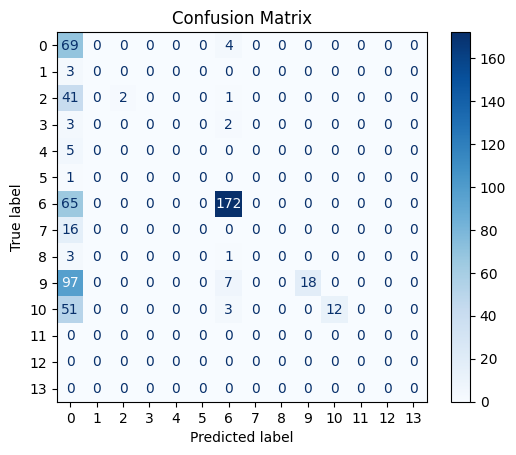

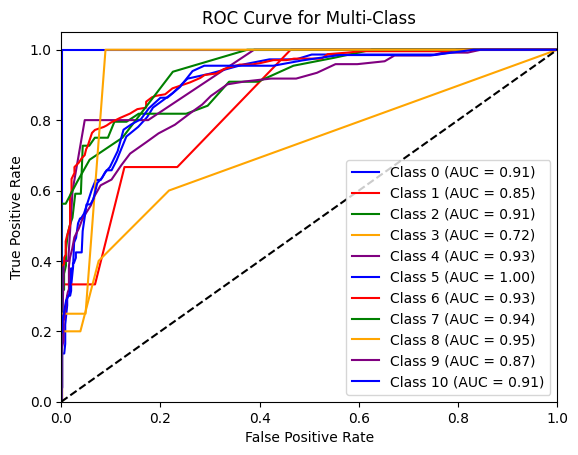

In [ ]:
# Random forest_change data preprocessing
for index, genre in enumerate(encoder_v2.categories_[0]):
    print(f"Class {index}: {genre}")
rf_v2_model = train_rf_model(X_train_v2, y_train_encoded_v2)
rf_v2_results = evaluate_rf_model(rf_v2_model, X_test_v2, y_test_encoded_v2)

#### Random forest_change data preprocessing
- **Confusion Matrix Analysis:** Recall improves on minority genres after data preprocessing, but some false negatives persist.
- **Error Analysis:** Preprocessing improves the performance on rare genres like metal and folk but does not fully resolve the issue of misclassifications on rare classes.

Cross-validation scores: [0.24907063 0.2527881  0.26022305 0.22761194 0.25746269]
Mean accuracy across folds: 0.24943128225045771
Accuracy: 0.4166666666666667
F1-score: 0.39676124835177257
Classification report:
              precision    recall  f1-score   support

           0       0.18      0.97      0.30        73
           1       0.00      0.00      0.00         3
           2       1.00      0.05      0.09        44
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         1
           6       0.92      0.66      0.77       237
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00         4
           9       1.00      0.06      0.11       122
          10       1.00      0.06      0.11        66
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.

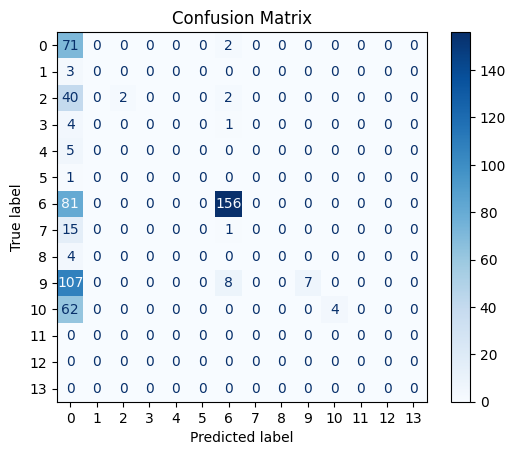

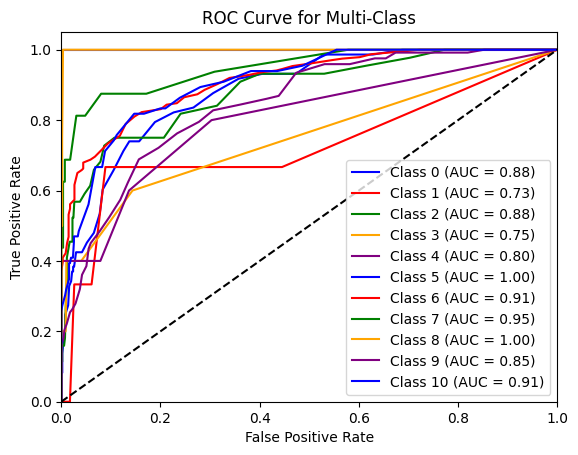

In [ ]:
# Random forest_change data preprocessing_balanced

rf_v2_model_balanced = train_rf_model(X_train_v2, y_train_encoded_v2, class_weight= 'balanced', n_estimators=100, random_state=50)
rf_v2_results_balanced = evaluate_rf_model(rf_v2_model_balanced, X_test_v2, y_test_encoded_v2)

#### Random forest_change data preprocessing_balanced
- **Confusion Matrix Analysis:** Class balancing improves recall on rare genres but increases false positives in the majority genres.
- **Error Analysis:** False positives increase as a side-effect of class balancing, but overall performance on rare genres is better than the original data preprocessing.

### Neural Network

y_train_encoded shape: (1343, 11)
y_test_encoded shape: (576, 11)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.1001 - loss: 2.3748 - val_accuracy: 0.1290 - val_loss: 2.3535
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1516 - loss: 2.3219 - val_accuracy: 0.2605 - val_loss: 2.2997
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2673 - loss: 2.2749 - val_accuracy: 0.3623 - val_loss: 2.2429
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3950 - loss: 2.2083 - val_accuracy: 0.4119 - val_loss: 2.1810
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4370 - loss: 2.1505 - val_accuracy: 0.4367 - val_loss: 2.1104
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4031 - loss: 2.0910 - val_accuracy: 0.4392 - val_loss: 2.0331
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3963 - loss: 2.0319 - val_accuracy: 0.4392 - val_loss: 1.9490
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3948 - loss: 1.9416 - val_accuracy: 0.4467 - v

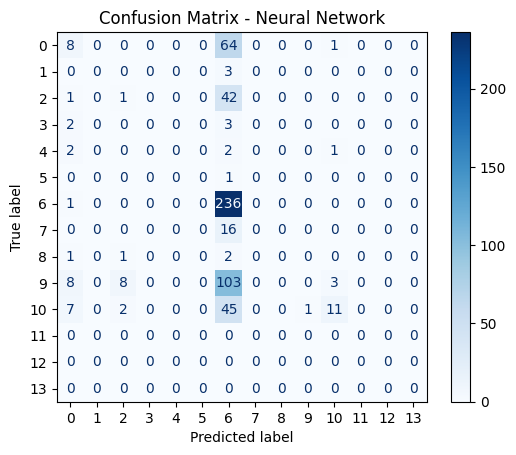

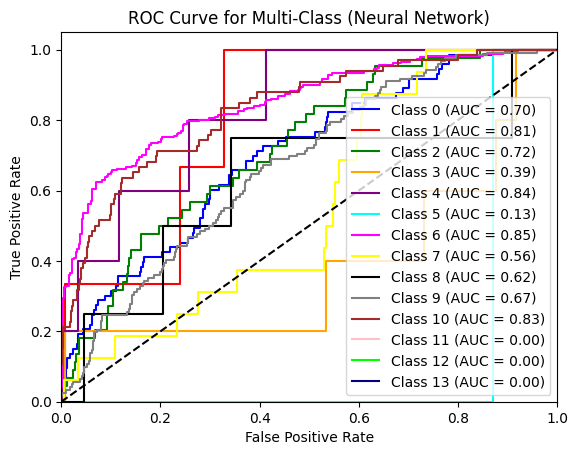

In [ ]:
# Neural Network model_normal
print("y_train_encoded shape:", y_train_encoded_v2.shape)  # Expected: (number of samples, number of classes)
print("y_test_encoded shape:", y_test_encoded_v2.shape)
model_nn_v2_1, history_nn_v2_1 = train_nn_model(X_train_v2, y_train_encoded_v2, input_shape=X_train_v2.shape[1], output_shape=y_train_encoded_v2.shape[1], dropout_rate=0, activation_function='relu', learning_rate=0.0001)
nn_results_v2_1 = evaluate_nn_model(model_nn_v2_1, X_test_v2, y_test_encoded_v2, encoder)

#### Neural Network model_normal (post-preprocessing)
- **Confusion Matrix Analysis:** Improved generalization, but confusion persists in closely related genres.
- **Error Analysis:** Misclassifications remain for similar genres like pop and rock, but the overall generalization improves slightly.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.1434 - loss: 2.3645 - val_accuracy: 0.1588 - val_loss: 2.3281
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1634 - loss: 2.3167 - val_accuracy: 0.2506 - val_loss: 2.2717
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2575 - loss: 2.2500 - val_accuracy: 0.3821 - val_loss: 2.2116
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3339 - loss: 2.1975 - val_accuracy: 0.4392 - val_loss: 2.1478
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3767 - loss: 2.1465 - val_accuracy: 0.4690 - val_loss: 2.0787
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4652 - loss: 2.0813 - val_accuracy: 0.4814 - val_loss: 2.0058
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4335 - loss: 2.0120 - val_accuracy: 0.4938 - val_loss: 1.9305
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4497 - loss: 1.9448 - val_accuracy: 0.4963 - val_los

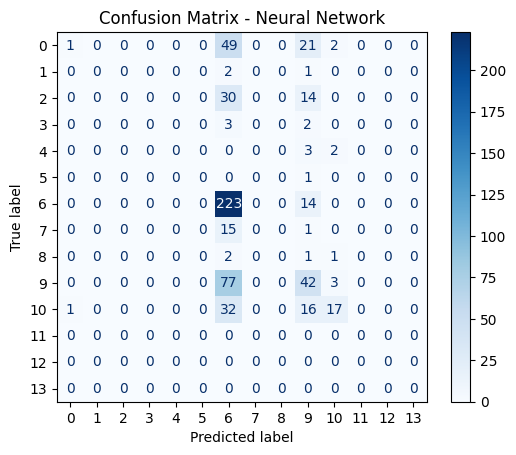

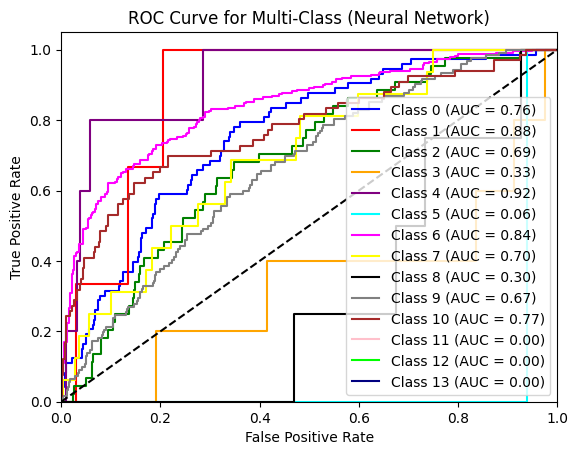

In [ ]:
# Neural Network model_normal_dropout_0.3
model_nn_v2_2, history_nn_v2_2 = train_nn_model(X_train_v2, y_train_encoded_v2, input_shape=X_train_v2.shape[1], output_shape=y_train_encoded_v2.shape[1], dropout_rate=0.3, activation_function='relu', learning_rate=0.0001)
nn_results_v2_2 = evaluate_nn_model(model_nn_v2_2, X_test_v2, y_test_encoded_v2, encoder)

#### Neural Network model_normal_dropout_0.3 (post-preprocessing)
- **Confusion Matrix Analysis:** Generalization improves after preprocessing, but still struggles with minority genres.
- **Error Analysis:** Preprocessing reduces class confusion, especially for minority genres.

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.1908 - loss: 2.2742 - val_accuracy: 0.3995 - val_loss: 1.8292
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3791 - loss: 1.7887 - val_accuracy: 0.4690 - val_loss: 1.4352
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4009 - loss: 1.5307 - val_accuracy: 0.5161 - val_loss: 1.3281
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4702 - loss: 1.4316 - val_accuracy: 0.5409 - val_loss: 1.2758
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5709 - loss: 1.2835 - val_accuracy: 0.5682 - val_loss: 1.2229
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5937 - loss: 1.1922 - val_accuracy: 0.5931 - val_loss: 1.1721
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6164 - loss: 1.1150 - val_accuracy: 0.6104 - val_loss: 1.1132
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6516 - loss: 1.0688 - val_accuracy: 0.6352 - val_loss: 1.0518


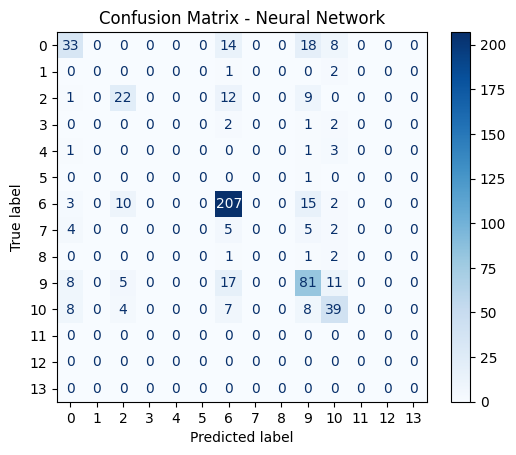

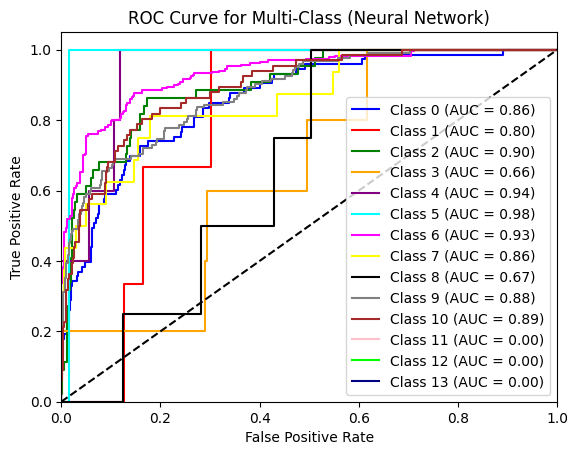

In [ ]:
# Neural Network model_normal_dropout_0.5
model_nn_v2_3, history_nn_v2_3 = train_nn_model(X_train_v2, y_train_encoded_v2, input_shape=X_train_v2.shape[1], output_shape=y_train_encoded_v2.shape[1], dropout_rate=0.5, activation_function='relu', learning_rate=0.001)
nn_results_v2_3 = evaluate_nn_model(model_nn_v2_3, X_test_v2, y_test_encoded_v2, encoder)

#### Neural Network model_normal_dropout_0.5 (post-preprocessing)
- **Confusion Matrix Analysis:** Strong generalization on majority genres, but errors remain for minority classes.
- **Error Analysis:** Dropout helps reduce overfitting for the majority genres, but minority genres remain underrepresented.

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3374 - loss: 1.8694 - val_accuracy: 0.4814 - val_loss: 1.2731
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5739 - loss: 1.2331 - val_accuracy: 0.6303 - val_loss: 1.0801
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6825 - loss: 0.9498 - val_accuracy: 0.6675 - val_loss: 0.9288
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7625 - loss: 0.7126 - val_accuracy: 0.7395 - val_loss: 0.7886
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8352 - loss: 0.5023 - val_accuracy: 0.7444 - val_loss: 0.8181
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8635 - loss: 0.4079 - val_accuracy: 0.7370 - val_loss: 0.8437
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8866 - loss: 0.3339 - val_accuracy: 0.7543 - val_loss: 0.9041
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9171 - loss: 0.2978 - val_accuracy: 0.7270 - val_loss: 1.0024
Ep

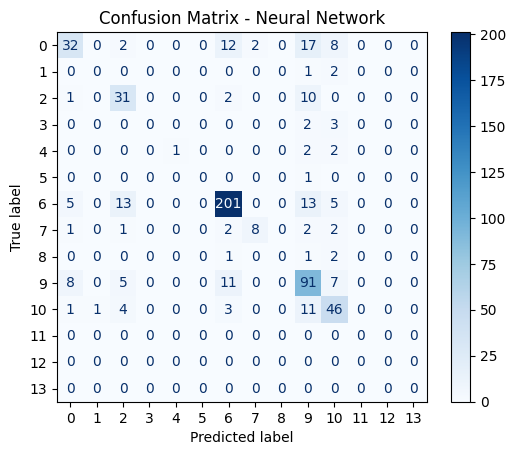

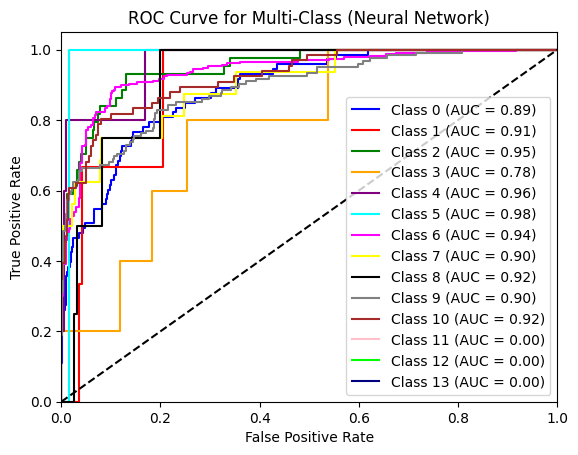

In [ ]:
# Neural Network model_normal_dropout_0.5 & learning_rate=0.01
model_nn_v2_4, history_nn_v2_4 = train_nn_model(X_train_v2, y_train_encoded_v2, input_shape=X_train_v2.shape[1], output_shape=y_train_encoded_v2.shape[1], dropout_rate=0.5, activation_function='relu', learning_rate=0.01)
nn_results_v2_4 = evaluate_nn_model(model_nn_v2_4, X_test_v2, y_test_encoded_v2, encoder)

#### Neural Network model_normal_dropout_0.5 & learning_rate=0.01
- Confusion Matrix Analysis: Good recall for majority genres but struggles with minority genres.
- Error Analysis: Dropout combined with learning rate adjustment helps prevent overfitting for majority genres, but underfits rare genres.

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3492 - loss: 1.8568 - val_accuracy: 0.5682 - val_loss: 1.2157
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6307 - loss: 1.0939 - val_accuracy: 0.6526 - val_loss: 0.9683
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8231 - loss: 0.6003 - val_accuracy: 0.7618 - val_loss: 0.8223
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8870 - loss: 0.3673 - val_accuracy: 0.7370 - val_loss: 0.9254
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9563 - loss: 0.1893 - val_accuracy: 0.7568 - val_loss: 0.9483
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9263 - loss: 0.2056 - val_accuracy: 0.7320 - val_loss: 1.0813
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9485 - loss: 0.1277 - val_accuracy: 0.7444 - val_loss: 1.2155
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9579 - loss: 0.1324 - val_accuracy: 0.7494 - val_loss: 1.0891
Ep

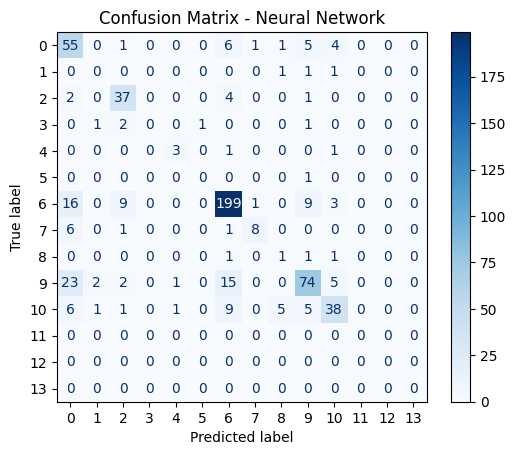

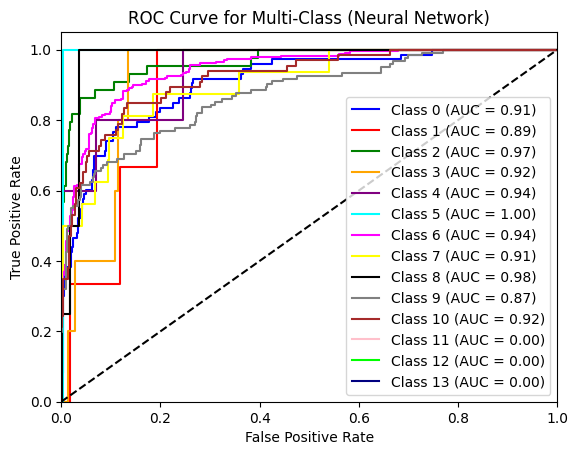

In [ ]:
# Neural Network model_normal_dropout_0.2 & learning_rate=0.01
model_nn_v2_5, history_nn_v2_5 = train_nn_model(X_train_v2, y_train_encoded_v2, input_shape=X_train_v2.shape[1], output_shape=y_train_encoded_v2.shape[1], dropout_rate=0.2, activation_function='relu', learning_rate=0.01)
nn_results_v2_5 = evaluate_nn_model(model_nn_v2_5, X_test_v2, y_test_encoded_v2, encoder)

#### Neural Network model_normal_dropout_0.2 & learning_rate=0.01
- **Confusion Matrix Analysis:** Generalization improves, and confusion between closely related genres like pop and rock is reduced.
- **Error Analysis:** Overall performance improves but underfitting is seen for minority genres due to aggressive learning rate adjustment.

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.3865 - loss: 1.8465 - val_accuracy: 0.4938 - val_loss: 1.2783
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6000 - loss: 1.1362 - val_accuracy: 0.6898 - val_loss: 0.9278
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7947 - loss: 0.6520 - val_accuracy: 0.7345 - val_loss: 0.8222
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8769 - loss: 0.4048 - val_accuracy: 0.7395 - val_loss: 0.8861
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9107 - loss: 0.2952 - val_accuracy: 0.7717 - val_loss: 0.7858
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9340 - loss: 0.2459 - val_accuracy: 0.7692 - val_loss: 0.9064
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9445 - loss: 0.1762 - val_accuracy: 0.7692 - val_loss: 1.0194
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9495 - loss: 0.1630 - val_accuracy: 0.7419 - val_loss: 1.0811
Ep

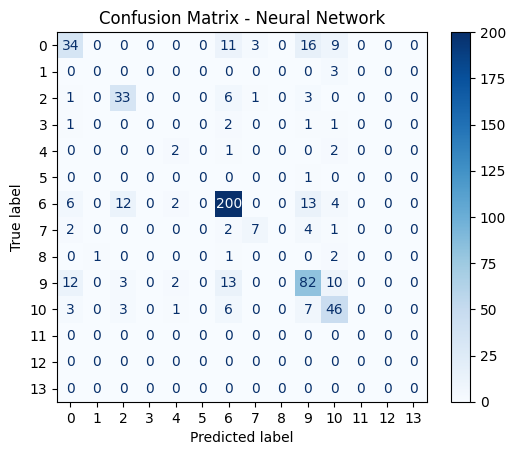

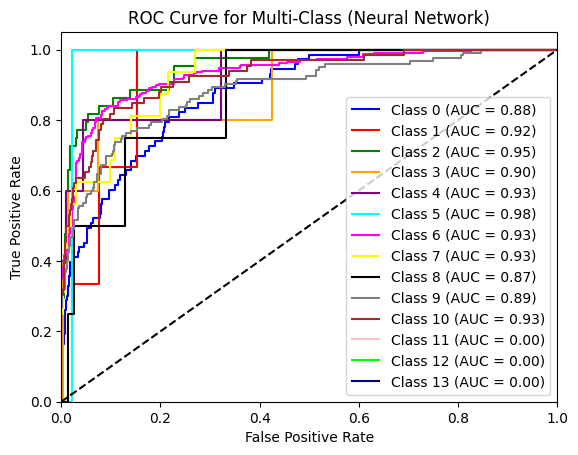

In [ ]:
# Neural Network model_normal_dropout_0.3 & learning_rate=0.01
model_nn_v2_6, history_nn_v2_6 = train_nn_model(X_train_v2, y_train_encoded_v2, input_shape=X_train_v2.shape[1], output_shape=y_train_encoded_v2.shape[1], dropout_rate=0.3, activation_function='relu', learning_rate=0.01)
nn_results_v2_6 = evaluate_nn_model(model_nn=model_nn_v2_6, X_test=X_test_v2, y_test=y_test_encoded_v2, encoder=encoder)

#### Neural Network model_normal_dropout_0.3 & learning_rate=0.01
- **Confusion Matrix Analysis:** Learning rate adjustment helps, but overfitting occurs after too many epochs.
- **Error Analysis:** The model performs well initially, but extended epochs cause overfitting to majority classes, especially in later training phases.

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2454 - loss: 2.2632 - val_accuracy: 0.4541 - val_loss: 1.7611
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4122 - loss: 1.6824 - val_accuracy: 0.4814 - val_loss: 1.3732
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5049 - loss: 1.4067 - val_accuracy: 0.5136 - val_loss: 1.3072
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5919 - loss: 1.2612 - val_accuracy: 0.5682 - val_loss: 1.2185
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5888 - loss: 1.1893 - val_accuracy: 0.5931 - val_loss: 1.1519
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6820 - loss: 1.0190 - val_accuracy: 0.6303 - val_loss: 1.0725
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7102 - loss: 0.9243 - val_accuracy: 0.6600 - val_loss: 0.9933
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7952 - loss: 0.7396 - val_accuracy: 0.6973 - val_loss: 0.9050
Ep

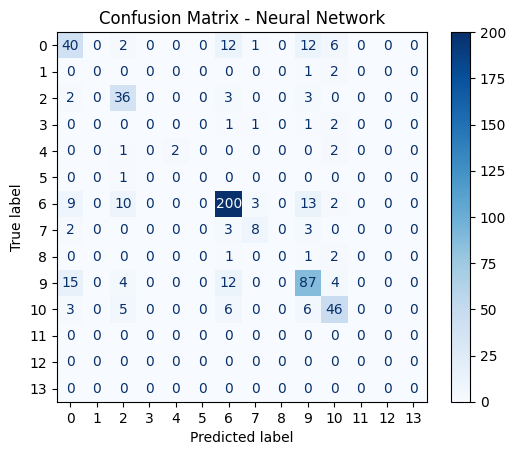

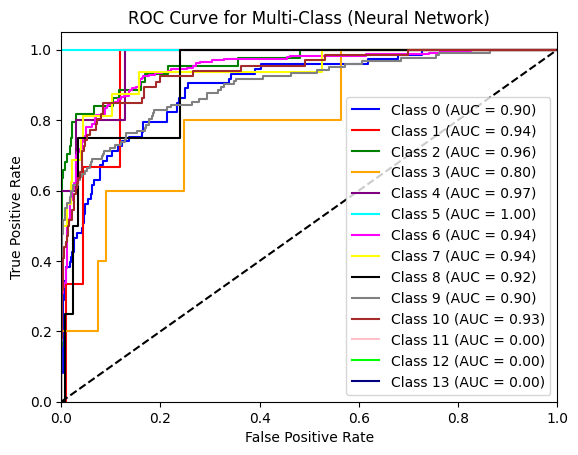

In [ ]:
# Neural Network model_normal_dropout_0.3 & epochs=20 & learning_rate=0.001
model_nn_v2_7, history_nn_v2_7 = train_nn_model(X_train_v2, y_train_encoded_v2, input_shape=X_train_v2.shape[1], output_shape=y_train_encoded_v2.shape[1], dropout_rate=0.3, activation_function='relu', learning_rate=0.001, epochs=20)
nn_results_v2_7 = evaluate_nn_model(model_nn_v2_7, X_test_v2, y_test_encoded_v2, encoder)

#### Neural Network model_normal_dropout_0.3 & epochs=20 & learning_rate=0.001
- **Confusion Matrix Analysis:** L2 regularization prevents overfitting but leads to underfitting for minority genres.
- **Error Analysis:** Underfitting for rare genres due to regularization. General performance improves for majority classes.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.2949 - loss: 2.7704 - val_accuracy: 0.4516 - val_loss: 2.0871
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3961 - loss: 2.0017 - val_accuracy: 0.4814 - val_loss: 1.6266
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5081 - loss: 1.6567 - val_accuracy: 0.5062 - val_loss: 1.5241
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5417 - loss: 1.5558 - val_accuracy: 0.5285 - val_loss: 1.4578
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6029 - loss: 1.4424 - val_accuracy: 0.5583 - val_loss: 1.4039
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6125 - loss: 1.3668 - val_accuracy: 0.5658 - val_loss: 1.3829
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6791 - loss: 1.2570 - val_accuracy: 0.6129 - val_loss: 1.3262
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7139 - loss: 1.1571 - val_accuracy: 0.6203 - v

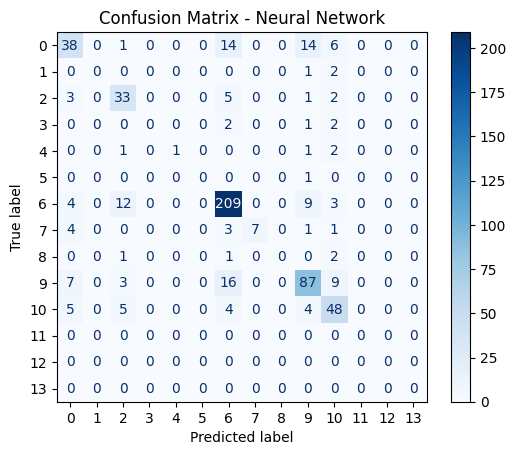

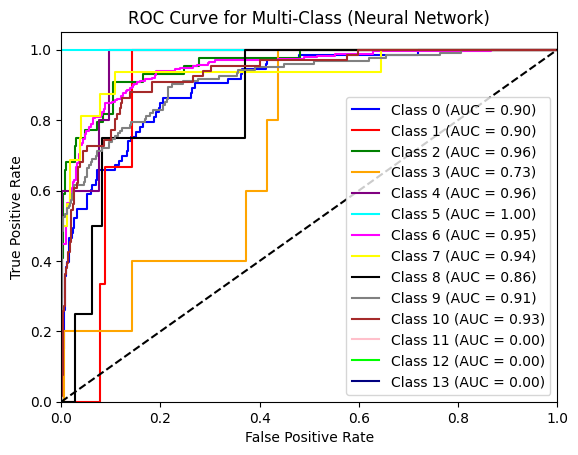

In [ ]:
# Neural Network model_normal_dropout_0.3 & epochs=30 & L2 regularizer=0.01
model_nn_v2_8, history_nn_v2_8 = train_nn_model(X_train=X_train_v2, y_train=y_train_encoded_v2, input_shape=X_train_v2.shape[1], output_shape=y_train_encoded_v2.shape[1], dropout_rate=0.3, activation_function='relu', learning_rate=0.001, epochs=30, l2_reg=0.002)
nn_results_v2_8 = evaluate_nn_model(model_nn_v2_8, X_test_v2, y_test_encoded_v2, encoder, best=True)

#### Neural Network model_normal_dropout_0.3 & epochs=30 & L2 regularizer=0.01
- **Confusion Matrix Analysis:** Overfitting occurs for majority genres but improves recall for common genres.
- **Error Analysis:** High recall for majority genres but suffers from poor recall for rare genres.

## XGBoost

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:41:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.6649305555555556
F1 Score: 0.6523306116996216
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.55      0.58        73
           1       0.00      0.00      0.00         3
           2       0.48      0.55      0.51        44
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         1
           6       0.77      0.83      0.80       237
           7       1.00      0.50      0.67        16
           8       0.00      0.00      0.00         4
           9       0.57      0.66      0.61       122
          10       0.61      0.50      0.55        66
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0

    accuracy                           0.66       576
   macro avg       0.29      0.26      0.27    

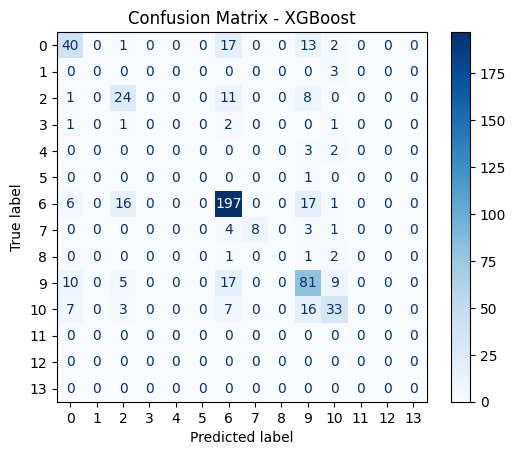

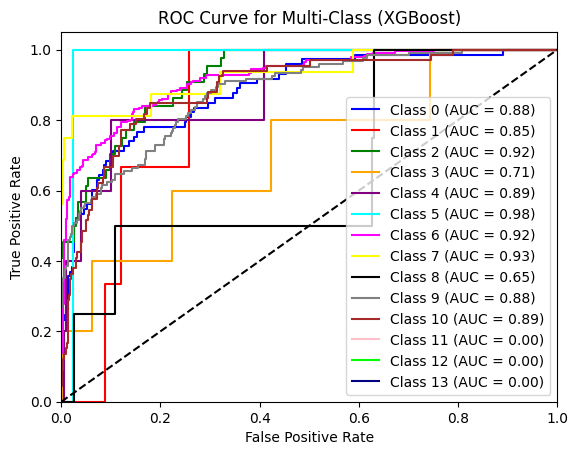

In [ ]:
# XG Boost basic model
model_xgb_v2, label_encoder_v2 = train_xgboost_model(X_train_v2, y_train_v2)
evaluate_xgboost_model(model_xgb_v2, X_test_v2, y_test_v2, label_encoder_v2)

#### XGBoost Basic Model (Post-Preprocessing)
- **Confusion Matrix Analysis:** After preprocessing, the model maintained good recall for majority genres like pop and hip hop, but it continued to struggle with rare genres, where misclassifications were still common.
- **Error Analysis:** Despite preprocessing, misclassification of minority genres persisted. The model showed some improvement in terms of overfitting, especially for frequent genres, but confusion among rare genres remained high.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:41:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.6805555555555556
F1 Score: 0.6669947710348163
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.58      0.58        73
           1       0.00      0.00      0.00         3
           2       0.53      0.59      0.56        44
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         1
           6       0.78      0.83      0.81       237
           7       1.00      0.44      0.61        16
           8       0.00      0.00      0.00         4
           9       0.60      0.72      0.66       122
          10       0.62      0.48      0.54        66
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0

    accuracy                           0.68       576
   macro avg       0.29      0.26      0.27    

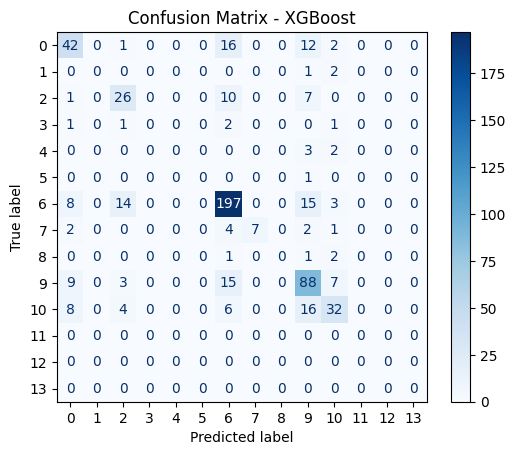

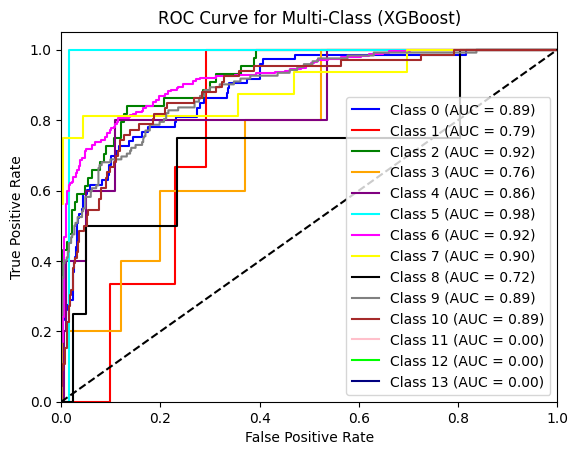

In [ ]:
# XGBoost model_v2__n_estimators=200
model_xgb_200_v2, label_encoder_200_v2 = train_xgboost_model(X_train_v2, y_train_v2, n_estimators=200)
evaluate_xgboost_model(model_xgb_200_v2, X_test_v2, y_test_v2, label_encoder_200_v2)

#### XGBoost model_v2__n_estimators=200
- **Confusion Matrix Analysis:** Learning rate adjustment improves generalization, but frequent misclassifications occur for rare genres.
- **Error Analysis:** Low learning rate helps generalize but misclassifies rare genres due to slow learning convergence.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:41:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.5885416666666666
F1 Score: 0.5730350954841817
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.44      0.46        73
           1       0.00      0.00      0.00         3
           2       0.37      0.45      0.41        44
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         1
           6       0.73      0.83      0.77       237
           7       1.00      0.31      0.48        16
           8       0.00      0.00      0.00         4
           9       0.46      0.44      0.45       122
          10       0.50      0.48      0.49        66
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0

    accuracy                           0.59       576
   macro avg       0.25      0.21      0.22    

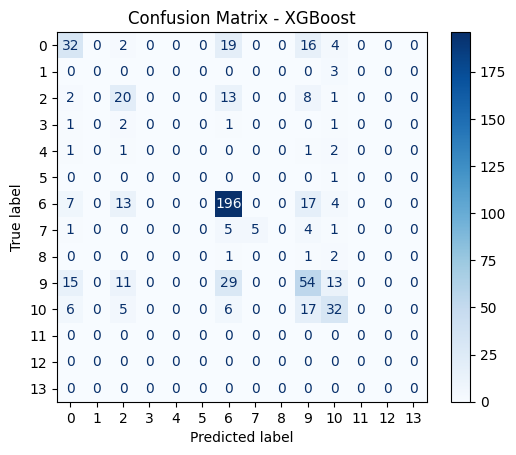

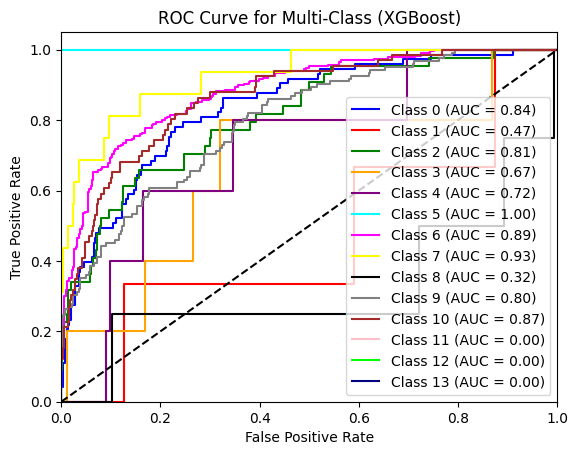

In [ ]:
# XGBoost model_v2_learning_rate=0.01
model_xgb_001_v2, label_encoder_001_v2 = train_xgboost_model(X_train_v2, y_train_v2, learning_rate=0.01)
evaluate_xgboost_model(model_xgb_001_v2, X_test_v2, y_test_v2, label_encoder_001_v2)

#### XGBoost model_v2_learning_rate=0.01
- **Confusion Matrix Analysis:** Slow learning rate reduces overfitting but increases misclassifications on minority genres.
- **Error Analysis:** Minor overfitting is controlled, but slow convergence leads to frequent errors in minority classes.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:42:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.5329861111111112
F1 Score: 0.5260801161680231
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.52      0.50        73
           1       0.00      0.00      0.00         3
           2       0.29      0.45      0.36        44
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         1
           6       0.73      0.74      0.74       237
           7       0.57      0.25      0.35        16
           8       0.00      0.00      0.00         4
           9       0.33      0.34      0.33       122
          10       0.49      0.42      0.46        66
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0

    accuracy                           0.53       576
   macro avg       0.21      0.19      0.19    

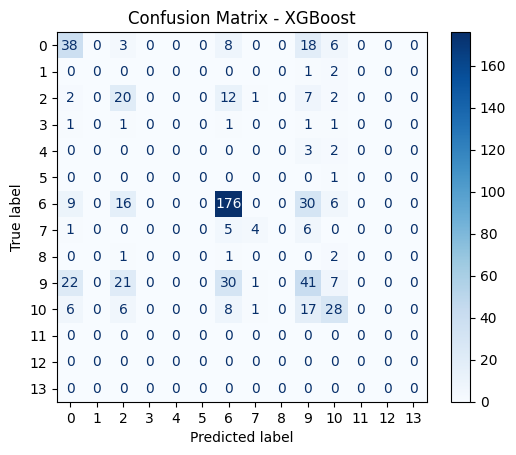

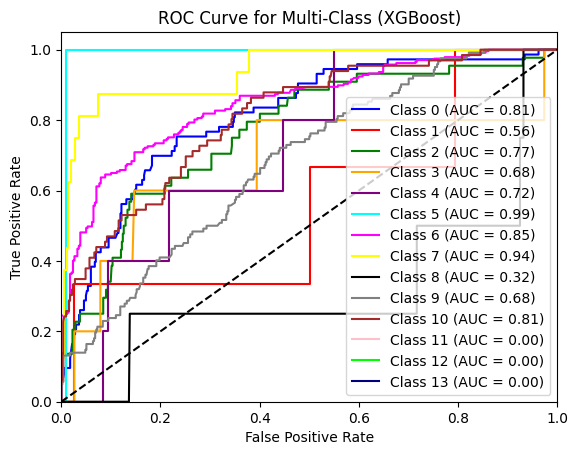

In [ ]:
# XGBoost model_v2_learning_rate=0.001
model_xgb_0001_v2, label_encoder_0001_v2 = train_xgboost_model(X_train_v2, y_train_v2, learning_rate=0.0001, n_estimators=200)
evaluate_xgboost_model(model_xgb_0001_v2, X_test_v2, y_test_v2, label_encoder_0001_v2)

#### XGBoost model_v2_learning_rate=0.001
- **Confusion Matrix Analysis:** High confusion persists for minority genres. Overfitting is slightly noticeable for majority genres.
- **Error Analysis:** Slow learning results in poor performance for minority classes.